In [2]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import time
import functools

Helper functions for loading and viewing the intput image data:

In [3]:
def load_img(path_to_img):
    max_dim = 512

    # Reading file
    img = tf.io.read_file(path_to_img)

    # Reading bytes to tensor image Tensor([height, width, channels])
    img = tf.image.decode_image(img, channels=3)

    # Converting image from uint8 to float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Getting height and width
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    
    # Rescaling to 512 with aspect ratio
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    # Doing the actual resizing / rescaling
    img = tf.image.resize(img, new_shape)

    # Adding batch dimension
    img = img[tf.newaxis, :]
    return img


def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

## Input data

In [4]:
content_path = 'images/feria1.jpeg'
style_path = 'images/sorolla_elena_playa.jpg'

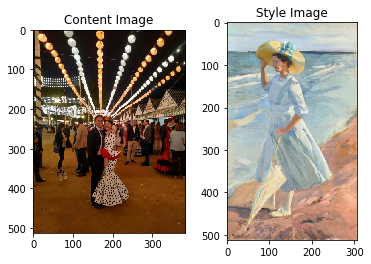

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Getting the style extractor model concept

* Style layers: first convolutional layers in the VGG19 blocks, these layers code the low level information about the image (shapes, edges, corners...)

In [6]:
# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

* Content layer: last layer in the VGG19 architecture, this layer code high level information about the image (dog, table, window...)

In [7]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

* Building the style extractor model
  * Creating a VGG19 model
  * Modify VGG19 to output style layers
  * Creating model from keras functional API

In [8]:
# Getting the core model without last dense layer at top (or end) of the model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Freezing the model
vgg.trainable = False

# Setting model ouputs: the outputs of the sytle layers
outputs = [vgg.get_layer(name).output for name in style_layers]

# Creationg of style extractor model
style_extractor = tf.keras.Model([vgg.input], outputs)

80142336/80134624 [==============================] - 3s 0us/step


* Testing the model: checking outputs


In [10]:
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 512, 306, 64)
  min:  0.0
  max:  800.1294
  mean:  29.241224

block2_conv1
  shape:  (1, 256, 153, 128)
  min:  0.0
  max:  2702.0923
  mean:  152.2888

block3_conv1
  shape:  (1, 128, 76, 256)
  min:  0.0
  max:  8764.396
  mean:  125.754074

block4_conv1
  shape:  (1, 64, 38, 512)
  min:  0.0
  max:  14136.161
  mean:  532.4715

block5_conv1
  shape:  (1, 32, 19, 512)
  min:  0.0
  max:  1881.1117
  mean:  41.701992



## Creating the style transfer model

This is the real part, the usual ML flow is always the same:

* Build the model
* Get a loss function
* Optimize the model by training
* Test the model

### Building the model

Class for building a Style and Content Extractor model:

In [11]:
class StyleContentModel(tf.keras.models.Model):
    """Class that implements a Style and Content extractors"""

    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  self.style_extractor(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def style_extractor(self, vgg_layer_names):
        """Gets a style extractor model from a core VGG19 model with output layers
        given by vgg_layer_names"""
        # Getting the core model without last dense layer at top (or end) of the model
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

        # Freezing the model
        vgg.trainable = False

        # Setting model ouputs: the outputs of the sytle layers
        outputs = [vgg.get_layer(name).output for name in vgg_layer_names]

        # Creationg of style extractor model
        style_extractor = tf.keras.Model([vgg.input], outputs)
        return style_extractor

    def gram_matrix(self, input_tensor):
        # Gram matrix: G = transpose(A) * A
        # In here we do this but the complicate way for TF optimization I guess
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

    def call(self, inputs):
        "Expects float input in [0,1] since image codification in TF is from 0 to 1"
        # Scale pixels values [0,1] to real pixel values [0, 255] since UINT8
        inputs = inputs*255.0
        
        # Preprocess input (reshape and all these stuff) before using the model
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        # Using the model
        outputs = self.vgg(preprocessed_input)
        
        # Unpacking ouptputs into sytye and content layer outputs
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # The style information is not on the layers output but on the correlation
        # of the layer output. The correlation for zero mean signals (vectors) is
        # just the dot product of the vector with itself, if multiple vectors, then
        # dot product of matrixes, or Gram Matrix 
        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        # Content layers output, dict with layer:values
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        # Style layers output
        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

Testing the extractor on the given sytle and content layers:

In [12]:
# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
# Content layers
content_layers = ['block5_conv2']

# Extractor for these layers
extractor = StyleContentModel(style_layers, content_layers)

### Coding a loss function

For optimization a loss function must be set. This is done by calculating the mean square error for the  image's output relative to each style (painter image) and content (the picture) targets, then take the weighted sum of these losses.

* The style target is the style extrated by our model for the painter image.
* The content target is the content extrated by our model for the input image to transform.

In [13]:
# Getting the content and style extracted for each of our images
style_image_extraction = extractor(style_image)
content_image_extraction = extractor(content_image)

# Setting the target style as the style of our style_image
style_targets = style_image_extraction['style']
content_targets = content_image_extraction['content']

The weighted loss will penalize higher the loss on the content weights (since we want the output picture to have the same contents (but with different sytle) than in the input image rather than see our picture transformed to the style of the artist but without being able to tell the original content of the image

* style_weight = $1\cdot 10^{-2}$
* content_weight = $1\cdot 10^{4}$

In [14]:
def style_content_loss(outputs, style_targets, content_targets):
    # Unpacking model outputs 
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Doing the MSE = 1/N sum( [y_true - y_pred]^2 ) for each layer in the style outputs
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    
    # Doing the MSE for each layer in the content output
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    # Weightening the losses by predefined weights
    style_weight = 1e-2
    content_weight = 1e4
    num_style_layers = len(outputs['style'])
    num_content_layers = len(outputs['content'])
    
    style_loss *= style_weight / num_style_layers
    content_loss *= content_weight / num_content_layers

    # Calculation of final loss
    loss = style_loss + content_loss
    return loss

There is also the concept of the total variation loss. This component of the loss is associated to the high frequencies components on the optimized image. This algorithm is known to produce a lot of high frequency artifacts. 

In order to reduce them we introduce the total variation loss term in the loss function. This term is just the quadratic mean of the high frequency components for X and Y axis of the image

In [15]:
def total_variation_loss(image):
    # Getting high frequency deltas in X and Y axis of the image
    x_deltas = image[:,:,1:,:] - image[:,:,:-1,:]
    y_deltas = image[:,1:,:,:] - image[:,:-1,:,:]
    
    # Computing cuadratic mean of the components: 1/N [ x(n)^2 ]
    mse_x_deltas = tf.reduce_mean(x_deltas**2)
    mse_y_deltas = tf.reduce_mean(y_deltas**2)
    
    # Adding the total variation loss term
    variation_loss = mse_x_deltas + mse_y_deltas
    
    return variation_loss

So in the end the total loss will be the style content loss plus the total variation loss. This way the optimizer will try to match the style and content without introducing to much high frequency deltas.

### Optimization

Now the loss function is implemented and we have our targets style and content specified we do the optimization of the image using the loss function against this targets.

For doing the optimization we need:

* Compute the gradient of the loss with respect to the image to optimize
* An optimization algorithm (they are all based on gradients) to uptade the image according to the gradient
* A loop to run the optimization algorithm, the training loop


In [16]:
# Choosing an optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Defining one optimization step into a function for later use inside of a loop

In [19]:
# Computing optimization
# Using tf.function for building a graph out of this python function
@tf.function()
def train_step(image):
    # Using Gradient Tape to compute derivatives
    with tf.GradientTape() as tape:
        # Extracting style and content of the image
        outputs = extractor(image)
        # Computing loss as style and content loss + total variation loss
        loss = style_content_loss(outputs, style_targets, content_targets)
        loss += total_variation_loss(image)

    # Compute derivative of the loss respect to the input image
    grad = tape.gradient(loss, image)
    
    # Using an optimizer for updating the image pixels with the gradient
    # (in the direction of the gradient, in the optimization direction)
    opt.apply_gradients([(grad, image)])
    
    # Clipping image values to 0,1 since it is the way TF handle images
    image.assign(tf.clip_by_value(image, 
                                  clip_value_min=0.0, 
                                  clip_value_max=1.0))

Testing the optimization step

W0608 18:41:54.113015 139955618563904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


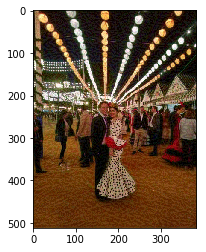

In [20]:
# Copying the content image to optimize
image = tf.Variable(content_image)

# Running a few steps and showing the output image
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

Running the optimization: doing the training

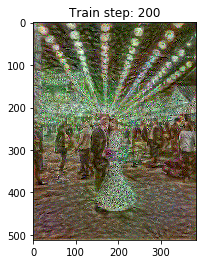

Epoch 2...................................................................

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for epoch in range(epochs):
    print("Epoch %s" % epoch, end='')
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')

    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))